# 태양광
***
### 3년(Day 0 ~ Day 1094) 동안의 기상 데이터, 발전량(TARGET) 데이터

### test는 2년동안의 기상데이터, 발전량(TARGET) 데이터

### 각 파일의 7일 동안의 데이터 전체 혹은 일부 활용하여 향후 2일 동안의 30분 간격 발전량 예측
****
- Hour - 시간
- Minute - 분
- DHI - 수평면 산란일사량(Diffuse Horizontal Irradiance (W/m2))
- DNI - 직달일사량(Direct Normal Irradiance (W/m2))
- WS - 풍속(Wind Speed (m/s))
- RH - 상대습도(Relative Humidity (%))
- T - 기온(Temperature (Degree C))
- Target - 태양광 발전량 (kW)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount = True)

Mounted at /content/gdrive/


In [316]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import time

import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg as qreg
import statsmodels.formula.api as smf

from tqdm import tnrange, tqdm_notebook

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor

In [555]:
cd /content/gdrive/My Drive/dacon/sun/data/train

/content/gdrive/My Drive/dacon/sun/data/train


In [556]:
train = pd.read_csv('train.csv')

In [557]:
cd /content/gdrive/My Drive/dacon/sun/data/test

/content/gdrive/My Drive/dacon/sun/data/test


In [558]:
for i in range(81) :
    globals() [f'test_{i}'] = pd.read_csv(f'{i}.csv')

In [559]:
### 각 데이터를 하나의 데이터로 통합
test = pd.DataFrame()
for i in range(81):
    test = pd.concat([test, globals()[f'test_{i}']], axis = 0, ignore_index = True)

In [560]:
cd /content/gdrive/My Drive/dacon/sun/data

/content/gdrive/My Drive/dacon/sun/data


In [561]:
submission = pd.read_csv('sample_submission.csv')

In [562]:
train.head()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0


In [563]:
test.head()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,2.7,34.42,0.0,0.0
1,0,0,30,0,0,2.7,34.17,0.1,0.0
2,0,1,0,0,0,2.7,34.23,0.2,0.0
3,0,1,30,0,0,2.7,33.99,0.3,0.0
4,0,2,0,0,0,2.8,33.97,0.4,0.0


In [564]:
train['DNI'] = np.log1p(train['DNI'])
train['DHI'] = np.log1p(train['DHI'])
train['WS'] = np.log1p(train['WS'])

In [565]:
test['DNI'] = np.log1p(test['DNI'])
test['DHI'] = np.log1p(test['DHI'])
test['WS'] = np.log1p(test['WS'])

In [566]:
train.Minute = train.Minute.map({30 : 1, 0: 0})
test.Minute = test.Minute.map({30 : 1, 0: 0})

In [567]:
train['hour_mean'] = train.Hour.map(train.groupby('Hour').TARGET.mean())
test['hour_mean'] = test.Hour.map(test.groupby('Hour').TARGET.mean())

In [568]:
train['day_mean'] = train.Day.map(train.groupby('Day').TARGET.mean())
test['day_mean'] = test.Day.map(test.groupby('Day').TARGET.mean())

In [569]:
train_after_2 = train.loc[train.Day <= 1092]
train_after_2['TARGET2'] = list(train.loc[train.Day >= 2].TARGET)
train_after_2['Day'] = train_after_2.Day % 9

In [577]:
pd.crosstab(train_after_2.Hour, train_after_2.Day, aggfunc = 'mean', values = train_after_2.TARGET2)

Day,0,1,2,3,4,5,6,7,8
Hour,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,1.290995,1.162550,1.235629,1.133332,1.252809,1.207061,1.287319,1.287320,1.397052
6,6.982467,6.699481,6.781786,6.784110,6.787019,7.190665,7.047917,7.434500,7.643912
7,17.288151,17.455947,17.607411,17.307457,16.603308,18.053373,17.693468,18.699256,18.398005
8,31.118618,31.544084,32.444681,31.092606,30.086744,32.367160,32.242244,34.181260,33.043662


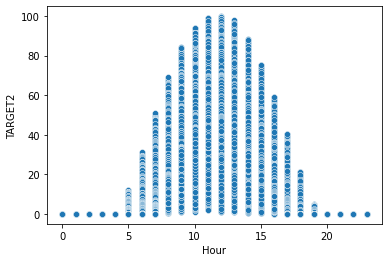

In [570]:
sns.scatterplot(train_after_2.Hour, train_after_2.TARGET2)

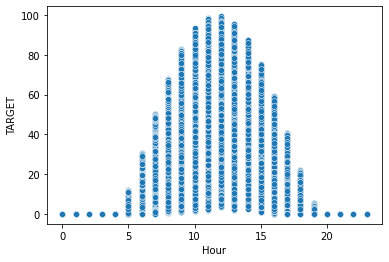

In [383]:
sns.scatterplot(test.Hour, test.TARGET)

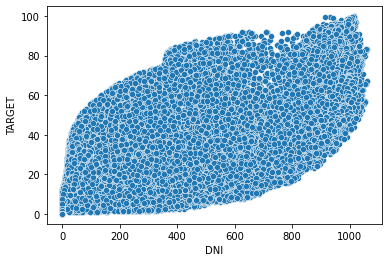

In [384]:
sns.scatterplot(train_after_2.DNI, train_after_2.TARGET)

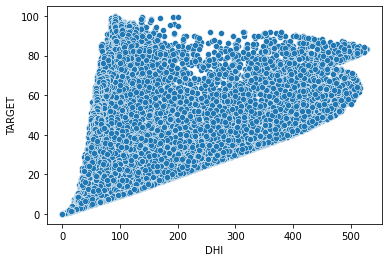

In [385]:
sns.scatterplot(train_after_2.DHI, train_after_2.TARGET)

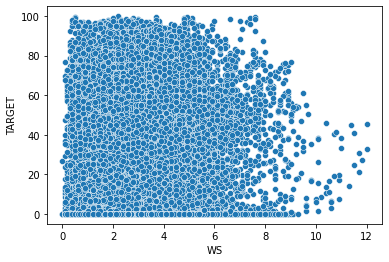

In [386]:
sns.scatterplot(train_after_2.WS, train_after_2.TARGET)

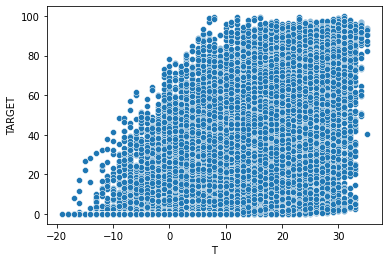

In [387]:
sns.scatterplot(train_after_2['T'], train_after_2.TARGET)

In [508]:
train_after_2.drop(['Hour', 'Minute'], axis =1 ,inplace = True)

In [509]:
target1 = test.query('Day in [0, 1]').drop(['Hour', 'Minute'], axis =1)
target2 = test.query('Day in [1, 2]').drop(['Hour', 'Minute'], axis =1)
target3 = test.query('Day in [2, 3]').drop(['Hour', 'Minute'], axis =1)
target4 = test.query('Day in [3, 4]').drop(['Hour', 'Minute'], axis =1)

target_list = [target1, target2, target3, target4]

In [510]:
actual1 = test.query('Day in [2,3]').TARGET
actual2 = test.query('Day in [3,4]').TARGET
actual3 = test.query('Day in [4,5]').TARGET
actual4 = test.query('Day in [5,6]').TARGET

actual_list = [actual1, actual2, actual3, actual4]

In [511]:
tr_X = train_after_2.drop('TARGET2', axis = 1).iloc[:int(train.shape[0] * .8), :]
tr_y = train_after_2.TARGET2.iloc[:int(train.shape[0] * .8)]

In [512]:
val_X = train_after_2.drop('TARGET2', axis = 1).iloc[int(train.shape[0] * .8):, :]
val_y = train_after_2.TARGET2.iloc[int(train.shape[0] * .8):]

In [513]:
target = test.query('Day in [5,6]').drop(['Hour', 'Minute'], axis = 1)

In [269]:
def pb_loss(true, pred, q) :
    
    L_list = []
    
    for i in range(len(true)) :
        
        if true.iloc[i] >= pred[i] :
            L = true.iloc[i] - pred[i]
            L *= q
            
        else :
            L1 = pred[i] - true.iloc[i]
            L2 = 1 - q
            L = L1 * L2
            
        L_list.append(L)
        
    return np.mean(L_list)

In [533]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [271]:
def tilted_loss(q, y, f):
    e = (y - f)
    return keras.backend.mean(keras.backend.maximum(q * e, (q - 1) * e), 
                              axis=-1)

In [535]:
train_after_2.describe()

,Day,DHI,DNI,WS,RH,T,TARGET,hour_mean,day_mean,TARGET2
count,52464.000000,52464.000000,52464.000000,52464.000000,52464.000000,52464.000000,52464.000000,52464.000000,52464.000000,52464.000000
mean,3.990851,2.220452,2.513576,1.160736,56.795208,9.297842,17.805046,17.790630,17.805046,17.807131
std,2.582588,2.344608,3.013604,0.397622,22.065222,10.179041,25.773161,21.489073,7.840329,25.773169
min,0.000000,0.000000,0.000000,0.000000,7.590000,-19.000000,0.000000,0.000000,1.958976,0.000000
25%,2.000000,0.000000,0.000000,0.875469,39.667500,1.000000,0.000000,0.000000,11.392848,0.000000
50%,4.000000,0.000000,0.000000,1.163151,57.600000,9.000000,0.000000,4.835883,17.353834,0.000000
75%,6.000000,4.477337,6.152733,1.435085,72.780000,17.000000,32.096062,34.676414,23.602189,32.180978
max,8.000000,6.270988,6.966024,2.564949,100.000000,35.000000,99.913939,57.088312,36.376067,99.913939


In [536]:
scaler = StandardScaler()
train_after_2[['RH', "T"]] = scaler.fit_transform(train_after_2[['RH','T']])

In [537]:
tr_X = train_after_2.drop('TARGET2', axis = 1).iloc[:int(train.shape[0] * .8), :]
tr_y = train_after_2.TARGET2.iloc[:int(train.shape[0] * .8)]

val_X = train_after_2.drop('TARGET2', axis = 1).iloc[int(train.shape[0] * .8):, :]
val_y = train_after_2.TARGET2.iloc[int(train.shape[0] * .8):]

In [538]:
test[['RH','T']] = scaler.transform(test[['RH','T']])

In [539]:
target1 = test.query('Day in [0, 1]').drop(['Hour', 'Minute'], axis =1)
target2 = test.query('Day in [1, 2]').drop(['Hour', 'Minute'], axis =1)
target3 = test.query('Day in [2, 3]').drop(['Hour', 'Minute'], axis =1)
target4 = test.query('Day in [3, 4]').drop(['Hour', 'Minute'], axis =1)

target_list = [target1, target2, target3, target4]

target = test.query('Day in [5,6]').drop(['Hour', 'Minute'], axis = 1)

In [540]:
for i, data in enumerate(zip(target_list, actual_list)) :
  print(f'{i + 1}번째 데이터셋으로 학습 및 검증 시작')
  for q in [.1, .2, .3, .4, .5, .6, .7, .8, .9] :
    pb_loss_list = []
    n = int(q * 10)
    print(f'quantile {q} regression start')
    model = keras.Sequential([
    Dense(32, activation='relu', input_shape=[tr_X.shape[1]]),
    Dropout(.3),
    Dense(32, activation='relu'),
    Dense(1)])
    optimizer = tf.keras.optimizers.RMSprop(0.0005)
    es = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min', restore_best_weights = True, verbose = 0)
    mc = ModelCheckpoint(f'1218keras_{n}.h5', mode = 'min', monitor = 'val_loss', patience = 3, save_weights_only=True, verbose = 0)
    model.compile(loss=lambda y, f: tilted_loss(q, y, f), optimizer=optimizer)
    
    model.fit(tr_X, tr_y, epochs=30, batch_size=32, verbose=0, validation_data = (val_X, val_y), callbacks = [es, mc])
    model.load_weights(f'1218keras_{n}.h5')
    pred = model.predict(data[0]).reshape(-1)
    pred = [0 if x < 0 else x for x in pred]
    loss = pb_loss(data[1], pred, q)
    pb_loss_list.append(loss)
  print(f'평균 loss는 {np.mean(pb_loss_list)}')

1번째 데이터셋으로 학습 및 검증 시작
quantile 0.1 regression start
quantile 0.2 regression start
quantile 0.3 regression start
quantile 0.4 regression start
quantile 0.5 regression start
quantile 0.6 regression start
quantile 0.7 regression start
quantile 0.8 regression start
quantile 0.9 regression start
평균 loss는 1.3373921781616955
2번째 데이터셋으로 학습 및 검증 시작
quantile 0.1 regression start
quantile 0.2 regression start
quantile 0.3 regression start
quantile 0.4 regression start
quantile 0.5 regression start
quantile 0.6 regression start
quantile 0.7 regression start
quantile 0.8 regression start
quantile 0.9 regression start
평균 loss는 1.453166277144172
3번째 데이터셋으로 학습 및 검증 시작
quantile 0.1 regression start
quantile 0.2 regression start
quantile 0.3 regression start
quantile 0.4 regression start
quantile 0.5 regression start
quantile 0.6 regression start
quantile 0.7 regression start
quantile 0.8 regression start
quantile 0.9 regression start
평균 loss는 1.60398727509496
4번째 데이터셋으로 학습 및 검증 시작
quantile 0.1 regressi

In [541]:
for q in [.1, .2, .3, .4, .5, .6, .7, .8, .9] :
    n = int(q * 10)
    model = keras.Sequential([
    Dense(32, activation='relu', input_shape=[tr_X.shape[1]]),
    Dropout(.3),
    Dense(32, activation='relu'),
    Dense(1)])
    model.load_weights(f'1218keras_{n}.h5')
    pred = model.predict(data[0]).reshape(-1)
    pred = [0 if x < 0 else x for x in pred]
    submission[f'q_{q}'] = pred
keras_submission = submission.copy()

In [542]:
keras_submission

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.000000,0.049334,0.093436,0.128385,0.431603
1,0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.000000,0.048241,0.092594,0.123386,0.424042
2,0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.000000,0.046228,0.092346,0.116116,0.419595
3,0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.000000,0.045305,0.091934,0.114513,0.416284
4,0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.000000,0.043394,0.092034,0.109666,0.411521
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.012189,0.041566,0.100346,0.222247,0.577880
7772,80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.011023,0.041866,0.100488,0.217018,0.552392
7773,80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.009948,0.041712,0.100738,0.212366,0.522321
7774,80.csv_Day8_23h00m,0.0,0.0,0.0,0.0,0.009015,0.042115,0.100806,0.208120,0.504407


In [517]:
keras_submission.describe()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
count,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000
mean,5.186897,9.655154,12.919978,14.455328,16.759580,18.997797,20.660004,21.438742,23.464161
std,7.387596,13.210887,17.304444,18.835122,21.227780,23.618212,25.777468,25.332878,27.820374
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.254150
25%,0.000000,0.000000,0.000000,0.000000,0.047113,0.000000,0.037936,0.036378,0.396109
50%,0.158063,0.880677,0.289929,0.623198,1.847452,2.195431,2.323933,3.943882,5.366031
75%,9.183468,18.500843,25.435527,29.174971,34.098569,39.467806,41.698201,44.872931,49.281040
max,29.848942,52.155571,63.556541,65.793991,74.430763,78.996613,89.468643,83.832108,92.936836


In [543]:
X = train_after_2.drop('TARGET2', axis = 1)
y = train_after_2.TARGET2

In [544]:
for i, data in enumerate(zip(target_list, actual_list)) :
    loss_list = []
    print(f'{i + 1}번째 데이터셋으로 학습 및 검증 시작')
    for qt in [.1, .2, .3, .4, .5, .6, .7, .8, .9] :
        
        gbm = GradientBoostingRegressor(random_state = 1216, loss = 'quantile', alpha = qt)
        gbm.fit(X, y)

        pred = gbm.predict(data[0])

        loss = pb_loss(data[1], pred, qt)
        loss_list.append(loss)
        print(f'{qt} quantile pinball_loss는 {np.mean(loss_list)}')

1번째 데이터셋으로 학습 및 검증 시작
0.1 quantile pinball_loss는 1.460588464190225
0.2 quantile pinball_loss는 1.8949782380613807
0.3 quantile pinball_loss는 2.188983277961136
0.4 quantile pinball_loss는 2.37405025630916
0.5 quantile pinball_loss는 2.461315362302894
0.6 quantile pinball_loss는 2.4721849093457373
0.7 quantile pinball_loss는 2.428827368577736
0.8 quantile pinball_loss는 2.333348917692275
0.9 quantile pinball_loss는 2.1902322055548864
2번째 데이터셋으로 학습 및 검증 시작
0.1 quantile pinball_loss는 1.4848481464869634
0.2 quantile pinball_loss는 1.963254215806804
0.3 quantile pinball_loss는 2.293459483460534
0.4 quantile pinball_loss는 2.4973044164863403
0.5 quantile pinball_loss는 2.5960947984350264
0.6 quantile pinball_loss는 2.6142702500637074
0.7 quantile pinball_loss는 2.5714449099804826
0.8 quantile pinball_loss는 2.471747511611989
0.9 quantile pinball_loss는 2.317403149569612
3번째 데이터셋으로 학습 및 검증 시작
0.1 quantile pinball_loss는 1.5744062627958002
0.2 quantile pinball_loss는 2.1094315937503993
0.3 quantile pinball_loss

In [545]:
for q in [.1, .2, .3, .4, .5, .6, .7, .8, .9] :
    
    gbm = GradientBoostingRegressor(random_state = 1216, loss = 'quantile', alpha = q)
    gbm.fit(X, y)

    gbm_pred = gbm.predict(target)
    submission[f'q_{q}'] = gbm_pred
gbm_submission = submission.copy()

In [546]:
gbm_submission

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001104,0.002267
1,0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001104,0.002267
2,0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001104,0.002267
3,0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001104,0.002267
4,0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001104,0.002267
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001104,0.002267
7772,80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001104,0.002267
7773,80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001104,0.002267
7774,80.csv_Day8_23h00m,0.0,0.0,0.0,0.0,0.0,0.000237,0.000621,0.001104,0.002267


In [547]:
for i, data in enumerate(zip(target_list, actual_list)) :
    loss_list = []
    print(f'{i + 1}번째 데이터셋으로 학습 및 검증 시작')
    for qt in [.1, .2, .3, .4, .5, .6, .7, .8, .9] :

        lgbm = LGBMRegressor(random_state = 1218, objective = 'quantile', metric = 'quantile', alpha = qt)
        lgbm.fit(X, y)

        pred = lgbm.predict(data[0])

        loss = pb_loss(data[1], pred, qt)

        loss_list.append(loss)
        print(f'{qt} quantile pinball_loss는 {np.mean(loss_list)}')

1번째 데이터셋으로 학습 및 검증 시작
0.1 quantile pinball_loss는 1.4602032131803944
0.2 quantile pinball_loss는 1.92548853095514
0.3 quantile pinball_loss는 2.244711950574458
0.4 quantile pinball_loss는 2.431887141607729
0.5 quantile pinball_loss는 2.5205416846787125
0.6 quantile pinball_loss는 2.5301982516465924
0.7 quantile pinball_loss는 2.467483500195677
0.8 quantile pinball_loss는 2.3538169942835623
0.9 quantile pinball_loss는 2.202380641792617
2번째 데이터셋으로 학습 및 검증 시작
0.1 quantile pinball_loss는 1.5062812212470986
0.2 quantile pinball_loss는 2.026852808272829
0.3 quantile pinball_loss는 2.3665627153450473
0.4 quantile pinball_loss는 2.5632941095911974
0.5 quantile pinball_loss는 2.6628567096212135
0.6 quantile pinball_loss는 2.6779674272740563
0.7 quantile pinball_loss는 2.615512774839489
0.8 quantile pinball_loss는 2.4960996142626657
0.9 quantile pinball_loss는 2.331111136649175
3번째 데이터셋으로 학습 및 검증 시작
0.1 quantile pinball_loss는 1.6319584451847193
0.2 quantile pinball_loss는 2.1984015375104606
0.3 quantile pinball_lo

In [548]:
for q in [.1, .2, .3, .4, .5, .6, .7, .8, .9] :
    
    lgbm = LGBMRegressor(random_state = 1218, objective = 'quantile', metric = 'quantile', alpha = q)
    lgbm.fit(X, y)

    lgbm_pred = lgbm.predict(data[0])
    submission[f'q_{q}'] = lgbm_pred
lgbm_submission = submission.copy()

In [549]:
keras_submission.iloc[:, 1:] *= .4
lgbm_submission.iloc[:, 1:] *= .2
gbm_submission.iloc[:, 1:] *= .4

In [550]:
submission.iloc[:, 1:] = lgbm_submission.iloc[:, 1:] + gbm_submission.iloc[:, 1:] + keras_submission.iloc[:, 1:]

In [551]:
submission.iloc[:, 1:] = submission.iloc[:, 1:].applymap(lambda x : 0 if x < 0 else x)

In [552]:
submission.describe()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
count,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000
mean,6.003677,10.472187,14.605124,16.360396,18.362976,20.058803,20.035817,23.618301,26.302442
std,8.184948,13.897139,18.934368,21.240912,23.562544,25.330102,25.115499,28.730052,30.843311
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.004080,0.000000,0.000000,0.098552
25%,0.000000,0.000000,0.000000,0.000000,0.001277,0.017234,0.038060,0.076027,0.187177
50%,0.165135,0.280664,0.829278,0.833230,1.317070,1.941796,2.692641,3.508924,5.883267
75%,12.151415,21.709971,30.918938,34.374000,37.958861,41.595670,41.325947,49.986844,55.640232
max,32.006014,50.354392,62.220165,69.938861,75.875752,81.585045,79.650967,89.532962,94.056048


In [553]:
submission

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.000000,0.019876,0.037747,0.052013,0.173967
1,0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.000000,0.019438,0.037410,0.050013,0.170942
2,0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.000000,0.018633,0.037311,0.047105,0.169164
3,0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.000000,0.018264,0.037146,0.046463,0.167839
4,0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.000000,0.017500,0.037186,0.044525,0.165934
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.004876,0.016768,0.040511,0.089557,0.232478
7772,80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.004409,0.016889,0.040568,0.087466,0.222283
7773,80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.003979,0.016827,0.040668,0.085605,0.210254
7774,80.csv_Day8_23h00m,0.0,0.0,0.0,0.0,0.003606,0.016988,0.040695,0.083907,0.203089


In [532]:
submission.to_csv('1218_2nd.csv', index = False)